# Backtesting a Mean Reverting Trading Strategy Part 3

## Or How to Backtest A Trading Strategy Using Python

## Introduction

Menu:
- review Sharpe ratio
- S&P 500 investment universe 
- S&P 400 investment universe
- S&P 600 investment universe

## Main

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from pandas import Series, DataFrame

In [4]:
import pickle

In [5]:
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline

### S&P 500 Index

Load historical data

In [7]:
with open('sp500_data.pickle', 'rb') as f:
    sp500 = pickle.load(f)

Consider closing prices

In [8]:
data = sp500.close

In [9]:
data.head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-05-09,37.7227,36.4477,123.5028,76.9614,43.4394,60.6682,21.59,35.0552,71.1754,59.59,...,25.9390,41.3795,85.0965,44.7737,26.7522,34.7281,49.9143,95.9139,27.4130,29.4467
2014-05-12,38.4174,37.5241,124.1869,77.9193,43.5308,61.6766,21.92,35.3070,71.5821,60.70,...,25.7028,42.1741,85.3302,45.0550,27.1364,35.5124,49.7835,96.7773,27.9511,29.7071
2014-05-13,38.7034,37.4479,122.3625,78.0415,43.3895,61.8431,21.55,35.6576,72.0251,60.81,...,25.7872,41.2278,85.4387,45.1908,27.3171,35.4471,50.0059,97.1610,27.5924,29.6299
2014-05-14,38.0360,37.0002,122.0948,78.0560,43.9464,62.2594,21.55,35.9004,71.2748,60.88,...,26.0234,40.9064,85.3803,44.7834,27.0686,35.2603,49.6070,96.8253,26.8278,29.5431
2014-05-15,37.1098,36.3810,123.1756,77.3922,43.7968,62.6632,21.20,35.2800,70.8861,60.20,...,25.7956,40.5850,84.1199,44.5893,26.7974,34.7654,48.9596,96.0770,26.6862,29.3696


In [10]:
data.tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-05-02,78.20,33.8523,166.78,209.15,78.47,77.06,264.77,78.78,179.39,279.64,...,55.92,118.90,77.29,51.50,32.95,79.54,101.74,123.21,49.48,103.15
2019-05-03,79.29,34.6899,163.27,211.75,78.71,79.14,271.75,78.69,176.98,285.58,...,56.58,119.02,77.47,55.05,32.95,82.29,102.72,124.31,50.05,103.75
2019-05-06,79.35,34.6500,161.99,208.48,79.26,78.31,268.95,79.07,176.26,283.66,...,56.51,118.81,77.13,54.73,32.65,80.08,102.41,125.55,49.68,103.33
2019-05-07,76.67,33.9100,160.66,202.86,77.95,77.46,261.98,76.91,173.94,277.07,...,56.58,117.81,76.72,54.83,32.67,79.17,101.47,123.39,48.71,101.37
2019-05-08,76.61,33.7500,158.62,202.90,77.99,78.72,260.27,76.22,173.82,276.77,...,55.88,117.69,76.84,54.95,32.09,79.13,100.49,122.56,48.19,101.86


In [11]:
data.describe()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,...,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,51.467024,41.343656,144.824652,133.794584,66.064139,84.739733,158.525886,48.392377,116.636740,138.544952,...,38.786547,57.890999,76.467798,53.016833,26.795565,50.742943,65.957073,111.383727,36.627797,58.504963
std,13.768604,6.216657,24.250751,38.325308,17.881638,9.845917,117.226499,12.213183,30.722033,68.878061,...,8.124638,21.478398,4.883311,7.892281,3.139932,16.191694,15.459884,10.036876,10.820941,19.725507
min,32.258600,24.539800,79.168700,76.961400,42.066600,60.668200,20.880000,33.935700,68.852300,59.590000,...,25.247700,32.609200,59.643400,34.178400,18.532600,28.968100,44.366900,89.236100,19.008100,29.196000
25%,39.221225,36.834425,130.553250,103.314650,52.521875,77.600350,75.840000,39.159175,90.555525,80.567500,...,31.174375,41.414825,73.431000,46.986675,24.215550,35.094975,52.731125,102.304000,26.912550,44.327550
50%,45.631150,40.848200,149.187400,118.695800,58.031100,84.243350,116.970000,42.809100,111.583650,105.580000,...,38.622750,51.057700,76.828250,53.996800,26.573400,47.844950,61.595700,112.414150,31.156350,50.342300
75%,65.193450,46.119900,161.834300,166.081025,82.894300,90.312650,236.567500,57.500400,147.791425,197.712500,...,45.139600,68.123175,79.625850,59.650550,29.473700,66.772550,79.238550,118.954900,46.685425,76.949925
max,81.940000,57.586600,199.159900,230.275400,116.445400,108.207500,449.750000,79.733700,182.670000,289.250000,...,57.360000,139.720000,87.124800,67.795300,35.000000,83.820000,104.390000,130.912800,57.511000,103.750000


Calculate daily returns

In [12]:
returns = data.pct_change()

In [13]:
# returns = (data.sub(data.shift(periods=1))).div(data.shift(periods=1))

In [14]:
returns.head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-12,0.018416,0.029533,0.005539,0.012446,0.002104,0.016622,0.015285,0.007183,0.005714,0.018627,...,-0.009106,0.019203,0.002746,0.006283,0.014361,0.022584,-0.002620,0.009002,0.019629,0.008843
2014-05-13,0.007445,-0.002031,-0.014691,0.001568,-0.003246,0.002700,-0.016880,0.009930,0.006189,0.001812,...,0.003284,-0.022438,0.001272,0.003014,0.006659,-0.001839,0.004467,0.003965,-0.012833,-0.002599
2014-05-14,-0.017244,-0.011955,-0.002188,0.000186,0.012835,0.006732,0.000000,0.006809,-0.010417,0.001151,...,0.009160,-0.007796,-0.000684,-0.009015,-0.009097,-0.005270,-0.007977,-0.003455,-0.027711,-0.002929
2014-05-15,-0.024351,-0.016735,0.008852,-0.008504,-0.003404,0.006486,-0.016241,-0.017281,-0.005454,-0.011170,...,-0.008754,-0.007857,-0.014762,-0.004334,-0.010019,-0.014036,-0.013051,-0.007728,-0.005278,-0.005873


In [15]:
returns.tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-05-02,0.009423,0.001180,0.018006,-0.006508,-0.005324,0.050007,-0.044393,0.000508,-0.010590,-0.013093,...,0.000358,0.019376,-0.017542,0.023653,-0.009321,-0.045023,-0.001962,0.016416,0.018526,0.013361
2019-05-03,0.013939,0.024743,-0.021046,0.012431,0.003058,0.026992,0.026363,-0.001142,-0.013434,0.021242,...,0.011803,0.001009,0.002329,0.068932,0.000000,0.034574,0.009632,0.008928,0.011520,0.005817
2019-05-06,0.000757,-0.001150,-0.007840,-0.015443,0.006988,-0.010488,-0.010304,0.004829,-0.004068,-0.006723,...,-0.001237,-0.001764,-0.004389,-0.005813,-0.009105,-0.026856,-0.003018,0.009975,-0.007393,-0.004048
2019-05-07,-0.033774,-0.021356,-0.008210,-0.026957,-0.016528,-0.010854,-0.025916,-0.027318,-0.013162,-0.023232,...,0.001239,-0.008417,-0.005316,0.001827,0.000613,-0.011364,-0.009179,-0.017204,-0.019525,-0.018968
2019-05-08,-0.000783,-0.004718,-0.012698,0.000197,0.000513,0.016266,-0.006527,-0.008972,-0.000690,-0.001083,...,-0.012372,-0.001019,0.001564,0.002189,-0.017753,-0.000505,-0.009658,-0.006727,-0.010675,0.004834


Calculate daily market returns
- stocks are equally weighted

In [16]:
market_returns = returns.mean(axis='columns')

Calculate weights of each stock
- the idea is to buy yesterday's losers; and 
- sell yesterday's winners

In [17]:
weights = - (returns.sub(market_returns, axis='index')).div(data.count(axis='columns'), axis='index')

In [18]:
weights.head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-05-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-12,-0.000013,-0.000036,0.000014,-2.107592e-07,0.000021,-0.000009,-0.000006,0.000011,0.000014,-0.000013,...,4.469024e-05,-0.000014,0.000020,0.000013,-0.000004,-2.133059e-05,0.000031,0.000007,-0.000015,0.000007
2014-05-13,-0.000018,0.000001,0.000028,-6.119837e-06,0.000004,-0.000008,0.000032,-0.000024,-0.000016,-0.000007,...,-9.693587e-06,0.000044,-0.000006,-0.000009,-0.000017,9.782534e-07,-0.000012,-0.000011,0.000024,0.000003
2014-05-14,0.000024,0.000013,-0.000007,-1.208940e-05,-0.000038,-0.000026,-0.000012,-0.000026,0.000010,-0.000014,...,-3.078479e-05,0.000005,-0.000010,0.000007,0.000007,-7.235211e-07,0.000005,-0.000005,0.000046,-0.000006
2014-05-15,0.000032,0.000016,-0.000037,-9.045500e-07,-0.000012,-0.000032,0.000015,0.000017,-0.000007,0.000005,...,-3.847390e-07,-0.000002,0.000012,-0.000010,0.000002,1.061933e-05,0.000009,-0.000003,-0.000008,-0.000006


In [19]:
weights.tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-05-02,-0.000019,-0.000003,-0.000036,0.000013,0.000010,-0.000099,0.000088,-0.000001,0.000021,0.000026,...,-9.823237e-07,-0.000039,3.446206e-05,-0.000047,0.000018,0.000089,0.000004,-3.278163e-05,-0.000037,-0.000027
2019-05-03,-0.000010,-0.000031,0.000059,-0.000007,0.000012,-0.000036,-0.000034,0.000020,0.000044,-0.000024,...,-5.591315e-06,0.000016,1.316846e-05,-0.000119,0.000018,-0.000051,-0.000001,1.012165e-07,-0.000005,0.000006
2019-05-06,-0.000011,-0.000007,0.000006,0.000021,-0.000023,0.000011,0.000011,-0.000019,-0.000001,0.000004,...,-6.996066e-06,-0.000006,-7.552554e-07,0.000002,0.000009,0.000044,-0.000003,-2.919854e-05,0.000005,-0.000001
2019-05-07,0.000035,0.000011,-0.000015,0.000022,0.000001,-0.000010,0.000020,0.000023,-0.000005,0.000014,...,-3.398021e-05,-0.000015,-2.100116e-05,-0.000035,-0.000033,-0.000009,-0.000013,2.540624e-06,0.000007,0.000006
2019-05-08,-0.000002,0.000006,0.000022,-0.000004,-0.000005,-0.000036,0.000009,0.000014,-0.000002,-0.000001,...,2.098072e-05,-0.000002,-6.615300e-06,-0.000008,0.000032,-0.000003,0.000016,9.802063e-06,0.000018,-0.000013


Set weights to 0 if price or return is NaN

In [20]:
weights[data.isna() | data.shift(periods=1).isna()] = 0

In [21]:
weights.head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-05-09,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2014-05-12,-0.000013,-0.000036,0.000014,-2.107592e-07,0.000021,-0.000009,-0.000006,0.000011,0.000014,-0.000013,...,4.469024e-05,-0.000014,0.000020,0.000013,-0.000004,-2.133059e-05,0.000031,0.000007,-0.000015,0.000007
2014-05-13,-0.000018,0.000001,0.000028,-6.119837e-06,0.000004,-0.000008,0.000032,-0.000024,-0.000016,-0.000007,...,-9.693587e-06,0.000044,-0.000006,-0.000009,-0.000017,9.782534e-07,-0.000012,-0.000011,0.000024,0.000003
2014-05-14,0.000024,0.000013,-0.000007,-1.208940e-05,-0.000038,-0.000026,-0.000012,-0.000026,0.000010,-0.000014,...,-3.078479e-05,0.000005,-0.000010,0.000007,0.000007,-7.235211e-07,0.000005,-0.000005,0.000046,-0.000006
2014-05-15,0.000032,0.000016,-0.000037,-9.045500e-07,-0.000012,-0.000032,0.000015,0.000017,-0.000007,0.000005,...,-3.847390e-07,-0.000002,0.000012,-0.000010,0.000002,1.061933e-05,0.000009,-0.000003,-0.000008,-0.000006


In [22]:
weights.tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-05-02,-0.000019,-0.000003,-0.000036,0.000013,0.000010,-0.000099,0.000088,-0.000001,0.000021,0.000026,...,-9.823237e-07,-0.000039,3.446206e-05,-0.000047,0.000018,0.000089,0.000004,-3.278163e-05,-0.000037,-0.000027
2019-05-03,-0.000010,-0.000031,0.000059,-0.000007,0.000012,-0.000036,-0.000034,0.000020,0.000044,-0.000024,...,-5.591315e-06,0.000016,1.316846e-05,-0.000119,0.000018,-0.000051,-0.000001,1.012165e-07,-0.000005,0.000006
2019-05-06,-0.000011,-0.000007,0.000006,0.000021,-0.000023,0.000011,0.000011,-0.000019,-0.000001,0.000004,...,-6.996066e-06,-0.000006,-7.552554e-07,0.000002,0.000009,0.000044,-0.000003,-2.919854e-05,0.000005,-0.000001
2019-05-07,0.000035,0.000011,-0.000015,0.000022,0.000001,-0.000010,0.000020,0.000023,-0.000005,0.000014,...,-3.398021e-05,-0.000015,-2.100116e-05,-0.000035,-0.000033,-0.000009,-0.000013,2.540624e-06,0.000007,0.000006
2019-05-08,-0.000002,0.000006,0.000022,-0.000004,-0.000005,-0.000036,0.000009,0.000014,-0.000002,-0.000001,...,2.098072e-05,-0.000002,-6.615300e-06,-0.000008,0.000032,-0.000003,0.000016,9.802063e-06,0.000018,-0.000013


Calculate the daily pnl
- we calculate weights based on close prices from day D and the previuos day D-1
- note that information at day D is only available at closing
- weight at day D is passed on to the next day D+1

In [23]:
lag = 1

In [24]:
pnl = (weights.shift(periods=lag)).mul(returns, axis='index')

In [25]:
pnl_net = pnl.sum(axis='columns')

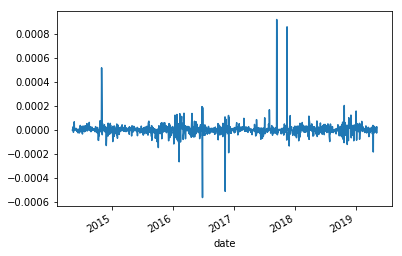

In [26]:
pnl_net.plot()

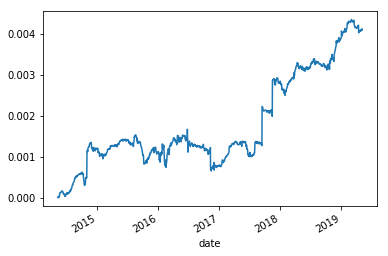

In [27]:
pnl_net.cumsum().plot()

Determine period of observation

In [28]:
period = ['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01']

Initialize performance measures

In [29]:
average_returns = []

In [30]:
std_returns = []

In [31]:
sharpe = []

Calculate performance measure

In [32]:
for i in range(len(period) - 1):
    
    # Period of observation
    start = period[i]
    end = period[i + 1]

    # Average daily returns     
    average_returns.append(pnl_net[start:end].mean())

    # Standard deviation of daily returns    
    std_returns.append(pnl_net[start:end].std())

    # Sharpe ratio
    sharpe.append(np.sqrt(252) * average_returns[i] / std_returns[i])

Create performance measure DataFrame

In [33]:
performance = pd.DataFrame({'Average Daily Returns': average_returns,
                           'Std Daily Returns': std_returns,
                           'Sharpe Ratio': sharpe},
                          index=period[:-1])

In [34]:
performance

,Average Daily Returns,Std Daily Returns,Sharpe Ratio
2014-01-01,7.252245e-06,0.000049,2.363955
2015-01-01,-2.509051e-07,0.000029,-0.136814
2016-01-01,-1.374419e-06,0.000068,-0.319982
2017-01-01,8.121202e-06,0.000084,1.535338
2018-01-01,4.238178e-06,0.000037,1.813055


### S&P MidCap 400 Index

### S&P SmallCap 600 Index

## Conclusion